<a href="https://colab.research.google.com/github/aarondelgiudice/thinkful_data_bootcamp/blob/master/unit_7/capstone/7_1a_Data_Wrangling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Wrangling
- Audio Features
- Lyric Data

First, we'll get our songs from Spotify. In addition to time and genre, Spotify likes to classify songs by mood. Some examples include "Feelin' Good", "Indie Sunshine", and "Calm Down". So we'll classify our songs, as either "happy" or "chill", as these are two major categories Spotify uses to classify music.

We can access specific playlists using spotiPy and the Spotify API. We'll download songs from a collection of playlists generated by Spotify. We'll assign target values to each song based on mood, songs marked as "happy" will be assigned a target value of 1 and "chill" songs will have a target value of 0.

After getting each song's unique ID we can pass them to spotiPy and get Spotify's audio features for each song. Features include numeric measures like "acousticness", "energy", "dancability", and musical qualities like "mode" and "tempo". Using spotiPy we can get additional information such as a "popularity" score, an "explicit" boolean, and artist and track names.

With our artist and track names we can feed those into the Lyrics Genius API and get lyric strings for each song if available.

With our audio features and lyrics we can analyze our songs using two approaches: supervised modeling and natural language processing.

In [0]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Load Data

In [0]:
#filename = "spotify_happy_data_raw"
#df_happy = pd.read_csv(filename + ".csv", index_col=0)

#df_happy.head()

In [0]:
#filename = "spotify_chill_data_raw"
#df_chill = pd.read_csv(filename + ".csv", index_col=0)

#df_chill.head()

In [0]:
filename = "spotify_lyrics_raw_batch1"
df_lyrics_batch1 = pd.read_csv(filename + ".csv", index_col=0)

print(df_lyrics_batch1.shape)
print(df_lyrics_batch1.dropna().shape)
df_lyrics_batch1.head()

(8802, 4)
(2795, 4)


,artist,album,track,lyrics_raw
id,,,,
005lwxGU1tms6HGELIcUv9,katy perry,one of the boys,i kissed a girl,[Verse 1]\nThis was never the way I planned\nN...
008EXmFGIPz7DWuOVIl5hP,rosie carney,your love is holy,your love is holy,[Verse 1]\nTake me down\nI want to stay\nIn yo...
00AVBnaQz7yRv8NTpNlCVU,albin lee meldau,lovers,bloodshot demo,[Verse 1]\nMonday morning be coming\nAs I hang...
00DTeE4nekCTgYz1QYHXSl,invention_,fokus,nature bump 000,Preparatory to anything else Mr Bloom brushed ...
00DrIsn8msfbQf3Let6UTD,voyager,bridge,third bridge,"In the year 1799, Captain Amasa Delano, of Dux..."


In [0]:
## change field size to avoid ParseError
#import sys
#import csv

#csv.field_size_limit(sys.maxsize)

filename = "spotify_lyrics_raw_batch2"
# set engine="python" to avoid ParseError
# set error_bad_lines=False
df_lyrics_batch2 = pd.read_csv(filename + ".csv", index_col=0,
                               engine="python", error_bad_lines=False)
#df_lyrics_batch2 = pd.read_csv(filename + ".csv", index_col=0)

print(df_lyrics_batch2.shape)
print(df_lyrics_batch2.dropna().shape)
df_lyrics_batch2.head()

(5619, 4)
(5602, 4)


,artist,album,track,lyrics_raw
id,,,,
005lwxGU1tms6HGELIcUv9,katy perry,one of the boys,i kissed a girl,[Verse 1]\nThis was never the way I planned\nN...
008EXmFGIPz7DWuOVIl5hP,rosie carney,your love is holy,your love is holy,[Verse 1]\nTake me down\nI want to stay\nIn yo...
00AVBnaQz7yRv8NTpNlCVU,albin lee meldau,lovers,bloodshot demo,[Verse 1]\nMonday morning be coming\nAs I hang...
00DTeE4nekCTgYz1QYHXSl,invention_,fokus,nature bump 000,Preparatory to anything else Mr Bloom brushed ...
00DrIsn8msfbQf3Let6UTD,voyager,bridge,third bridge,"In the year 1799, Captain Amasa Delano, of Dux..."


In [0]:
filename = "spotify_lyrics_raw_batch3"
df_lyrics_batch3 = pd.read_csv(filename + ".csv", index_col=0)

print(df_lyrics_batch3.shape)
print(df_lyrics_batch3["lyrics_raw"].dropna().shape)
df_lyrics_batch3.tail()

(8802, 4)
(2804,)


,artist,album,track,lyrics_raw
id,,,,
7zkDEBSxkcBVsStS4qBFpK,phoenix,wolfgang amadeus phoenix,lisztomania,NaN
7zqLBFKCBkk5IfbgKgH4VZ,zara larsson,spotify singles,sexual,NaN
7zrPswSV1yxrill5OyCuaU,curtis mayfield,superfly deluxe 25th anniversary edition,pusherman,NaN
7zs5zHtydDQ4RTEylVtXRp,sam feldt,gold,gold,NaN
7zuqsNtIkksF5U9OEjqXlk,canaan smith,like you that way,like you that way,NaN


In [0]:
## change field size to avoid ParseError
#import sys
#import csv

#csv.field_size_limit(sys.maxsize)

#filename = "lyric_test_data_clean"
## set engine="python" to avoid ParseError
## set error_bad_lines=False
#df_lyrics = pd.read_csv(filename + ".csv", index_col=0,
#                        engine="python", error_bad_lines=False)
#df_lyrics = pd.read_csv(filename + ".csv", index_col=0)
## make sure lyric data is type string
#df_lyrics['lyrics_raw'] = df_lyrics['lyrics_raw'].astype(str)
#df_lyrics['lyrics_clean'] = df_lyrics['lyrics_clean'].astype(str)
#df_lyrics.head()

## Spotify Data

In [0]:
# install spotiPy package
#! pip install spotipy

  Stored in directory: /root/.cache/pip/wheels/76/28/19/a86ca9bb0e32dbd4a4f580870250f5aeef852870578e0427e6
Successfully built spotipy


In [0]:
# import spotiPy
import spotipy
import spotipy.oauth2 as oauth2

### Connect to API

To use the Spotify API first create an app within the Spotify developer environment.

Go to the Spotify Developer page, log in and navigate to the **My Applications** page.

Create a new application and specify a name. Make note of the `Client ID` and `Client Secret`, they will be necessary later.

On the application creation screen set the `Redirect URLs field`. This is where your application goes after a success or failure to log in to Spotify.
Set the `Redirect URis field` to `localhost:8888`.

In [0]:
cid = None
secret = None
#username = "128062522"
username = "aarondelgiudice@gmail.com"

credentials = oauth2.SpotifyClientCredentials(
    client_id=cid,
    client_secret=secret)

token = credentials.get_access_token()

if token:
  sp = spotipy.Spotify(auth=token)
else:
  print("Can't get token for", username)

In [0]:
# test that this worked
lz_uri = 'spotify:artist:36QJpDe2go2KgaRleHCDTp'

results = sp.artist_top_tracks(lz_uri)

for track in results['tracks'][:10]:
    print('track    : ' + track['name'])
    print('audio    : ' + track['preview_url'])
    print('cover art: ' + track['album']['images'][0]['url'])
    print()

track    : Immigrant Song - Remaster
audio    : https://p.scdn.co/mp3-preview/8455599677a13017978dcd3f4b210937f0a16bcb?cid=682502831efa4a3992fc25308b2f8ff2
cover art: https://i.scdn.co/image/e6e513e68c4eefdfc7bc213b35061c9c30b42dfa

track    : Stairway to Heaven - Remaster
audio    : https://p.scdn.co/mp3-preview/8226164717312bc411f8635580562d67e191a754?cid=682502831efa4a3992fc25308b2f8ff2
cover art: https://i.scdn.co/image/557a6058e3de72bf37ffcd2c12dd5932276df344

track    : Whole Lotta Love - 1990 Remaster
audio    : https://p.scdn.co/mp3-preview/ce11b19a4d2de9976d7626df0717d0073863909c?cid=682502831efa4a3992fc25308b2f8ff2
cover art: https://i.scdn.co/image/5fa3a6cc1848ea743a293d2088046746d1b09608

track    : Black Dog - Remaster
audio    : https://p.scdn.co/mp3-preview/9b76619fd9d563a48d38cc90ca00c3008327b52e?cid=682502831efa4a3992fc25308b2f8ff2
cover art: https://i.scdn.co/image/557a6058e3de72bf37ffcd2c12dd5932276df344

track    : Good Times Bad Times - 1993 Remaster
audio    : htt

In [0]:
name = 'Radiohead'

results = sp.search(q='artist:' + name, type='artist')
items = results['artists']['items']
if len(items) > 0:
    artist = items[0]
    print(artist['name'], artist['images'][0]['url'])

Radiohead https://i.scdn.co/image/afcd616e1ef2d2786f47b3b4a8a6aeea24a72adc


### Get Spotify Data

In [0]:
# set user and playlist id
user = "128062522"
playlist_id="5IsedM4cczSbvvknpajDQt"

In [0]:
# get list of good tracks from playlist
happy_playlist = sp.user_playlist(user=user, playlist_id=playlist_id)

happy_tracks = happy_playlist["tracks"]
happy_songs = happy_tracks["items"] 

while happy_tracks['next']:
  happy_tracks = sp.next(happy_tracks)
  for item in happy_tracks["items"]:
    happy_songs.append(item)

happy_ids = [] 
for i in range(len(happy_songs)):
  happy_ids.append(happy_songs[i]['track']['id'])

In [0]:
# confirm this worked
print(len(happy_ids))
happy_ids[:5]

4911


['7Mpy3FMyXnYc7tCAIPE2fO',
 '5LWLVUBBCNYKPWOHDO0We7',
 '3HYXqOAm2Q8b2OyYqzv8d4',
 '0ilSmTNvpCFvTsKjvpav7m',
 '1BzdE75pSHlsqF2roxxEWk']

In [0]:
# set user and playlist id
user = "128062522"
playlist_id="5wnHJrGh8yVe8cOSPu7Qx5"

In [0]:
# get list of bad tracks from playlist
chill_playlist = sp.user_playlist(user=user, playlist_id=playlist_id)

chill_tracks = chill_playlist["tracks"]
chill_songs = chill_tracks["items"] 

while chill_tracks['next']:
  chill_tracks = sp.next(chill_tracks)
  for item in chill_tracks["items"]:
    chill_songs.append(item)

chill_ids = [] 
for i in range(len(chill_songs)):
  chill_ids.append(chill_songs[i]['track']['id'])

In [0]:
print(len(chill_ids))
chill_ids[:5]

4561


['0cLS7FslBJgsuWwJNRnPWB',
 '2mcmQR1Zq1wDl582Gm4aLC',
 '0AqMAXSzkIRMV0alAddJK8',
 '5nTGyhsQmk8NHlg71ZEmmo',
 '0cSudkwUpqc4maU7qzyF8U']

In [0]:
sp.audio_features(happy_ids[0])

[{'acousticness': 0.0485,
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/7Mpy3FMyXnYc7tCAIPE2fO',
  'danceability': 0.625,
  'duration_ms': 212783,
  'energy': 0.642,
  'id': '7Mpy3FMyXnYc7tCAIPE2fO',
  'instrumentalness': 0,
  'key': 10,
  'liveness': 0.147,
  'loudness': -5.611,
  'mode': 1,
  'speechiness': 0.0867,
  'tempo': 144.011,
  'time_signature': 4,
  'track_href': 'https://api.spotify.com/v1/tracks/7Mpy3FMyXnYc7tCAIPE2fO',
  'type': 'audio_features',
  'uri': 'spotify:track:7Mpy3FMyXnYc7tCAIPE2fO',
  'valence': 0.607}]

In [0]:
# get audio features from spotify
# set traget value for 'happy tracks' to 1
features = []
for i in range(0,len(happy_ids),50):
  audio_features = sp.audio_features(happy_ids[i:i+50])
  for track in audio_features:
    #try:
    if features.append(track):
      features[-1]['target'] = 1

len(features)

4911

In [0]:
features[0]

{'acousticness': 0.0485,
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/7Mpy3FMyXnYc7tCAIPE2fO',
 'danceability': 0.625,
 'duration_ms': 212783,
 'energy': 0.642,
 'id': '7Mpy3FMyXnYc7tCAIPE2fO',
 'instrumentalness': 0,
 'key': 10,
 'liveness': 0.147,
 'loudness': -5.611,
 'mode': 1,
 'speechiness': 0.0867,
 'tempo': 144.011,
 'time_signature': 4,
 'track_href': 'https://api.spotify.com/v1/tracks/7Mpy3FMyXnYc7tCAIPE2fO',
 'type': 'audio_features',
 'uri': 'spotify:track:7Mpy3FMyXnYc7tCAIPE2fO',
 'valence': 0.607}

In [0]:
# drop None values
features_noNone = [i for i in features if i]

# load data into DataFrame
df_happy = pd.DataFrame(features_noNone)

df_happy['target'] = 1

print(df_happy.shape)
df_happy.head()

(4906, 19)


,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence,target
0,0.0485,https://api.spotify.com/v1/audio-analysis/7Mpy...,0.625,212783,0.642,7Mpy3FMyXnYc7tCAIPE2fO,0.000000,10,0.1470,-5.611,1,0.0867,144.011,4,https://api.spotify.com/v1/tracks/7Mpy3FMyXnYc...,audio_features,spotify:track:7Mpy3FMyXnYc7tCAIPE2fO,0.607,1
1,0.5830,https://api.spotify.com/v1/audio-analysis/5LWL...,0.450,225453,0.520,5LWLVUBBCNYKPWOHDO0We7,0.000000,9,0.3500,-7.973,0,0.0353,110.894,4,https://api.spotify.com/v1/tracks/5LWLVUBBCNYK...,audio_features,spotify:track:5LWLVUBBCNYKPWOHDO0We7,0.683,1
2,0.0437,https://api.spotify.com/v1/audio-analysis/3HYX...,0.710,203500,0.827,3HYXqOAm2Q8b2OyYqzv8d4,0.000013,0,0.0896,-5.244,1,0.0320,110.003,4,https://api.spotify.com/v1/tracks/3HYXqOAm2Q8b...,audio_features,spotify:track:3HYXqOAm2Q8b2OyYqzv8d4,0.833,1
3,0.0473,https://api.spotify.com/v1/audio-analysis/0ilS...,0.782,202941,0.556,0ilSmTNvpCFvTsKjvpav7m,0.000000,7,0.1030,-6.066,1,0.0478,102.039,4,https://api.spotify.com/v1/tracks/0ilSmTNvpCFv...,audio_features,spotify:track:0ilSmTNvpCFvTsKjvpav7m,0.745,1
4,0.6260,https://api.spotify.com/v1/audio-analysis/1Bzd...,0.687,156213,0.352,1BzdE75pSHlsqF2roxxEWk,0.000151,8,0.1330,-8.229,1,0.0759,122.955,4,https://api.spotify.com/v1/tracks/1BzdE75pSHls...,audio_features,spotify:track:1BzdE75pSHlsqF2roxxEWk,0.155,1


In [0]:
# get audio features from spotify
# set traget value for 'chill tracks' to 0
features = []

for i in range(0,len(chill_ids),50):
  audio_features = sp.audio_features(chill_ids[i:i+50])
  for track in audio_features:
    if features.append(track):
      features[-1]['target'] = 1
    
len(features)

4561

In [0]:
#drop None values
features_noNone = [i for i in features if i]
# load data into DataFrame
df_chill = pd.DataFrame(features_noNone)
df_chill['target'] = 0

print(df_chill.shape)
df_chill.head()

(4560, 19)


,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence,target
0,0.3360,https://api.spotify.com/v1/audio-analysis/0cLS...,0.621,201997,0.692,0cLS7FslBJgsuWwJNRnPWB,0.000458,7,0.0877,-5.837,0,0.0435,144.968,4,https://api.spotify.com/v1/tracks/0cLS7FslBJgs...,audio_features,spotify:track:0cLS7FslBJgsuWwJNRnPWB,0.446,0
1,0.6440,https://api.spotify.com/v1/audio-analysis/2mcm...,0.803,205049,0.662,2mcmQR1Zq1wDl582Gm4aLC,0.901000,0,0.1510,-8.073,1,0.0308,105.009,4,https://api.spotify.com/v1/tracks/2mcmQR1Zq1wD...,audio_features,spotify:track:2mcmQR1Zq1wDl582Gm4aLC,0.814,0
2,0.0651,https://api.spotify.com/v1/audio-analysis/0AqM...,0.570,211065,0.460,0AqMAXSzkIRMV0alAddJK8,0.000019,4,0.1310,-9.841,0,0.2800,203.579,4,https://api.spotify.com/v1/tracks/0AqMAXSzkIRM...,audio_features,spotify:track:0AqMAXSzkIRMV0alAddJK8,0.659,0
3,0.3170,https://api.spotify.com/v1/audio-analysis/5nTG...,0.798,256053,0.560,5nTGyhsQmk8NHlg71ZEmmo,0.000292,1,0.1330,-6.574,1,0.0469,106.971,4,https://api.spotify.com/v1/tracks/5nTGyhsQmk8N...,audio_features,spotify:track:5nTGyhsQmk8NHlg71ZEmmo,0.571,0
4,0.1910,https://api.spotify.com/v1/audio-analysis/0cSu...,0.747,203893,0.539,0cSudkwUpqc4maU7qzyF8U,0.000060,2,0.3560,-6.904,1,0.0860,76.539,4,https://api.spotify.com/v1/tracks/0cSudkwUpqc4...,audio_features,spotify:track:0cSudkwUpqc4maU7qzyF8U,0.727,0


### More API Data

In [0]:
print(df_happy['id'][:5])

0    7Mpy3FMyXnYc7tCAIPE2fO
1    5LWLVUBBCNYKPWOHDO0We7
2    3HYXqOAm2Q8b2OyYqzv8d4
3    0ilSmTNvpCFvTsKjvpav7m
4    1BzdE75pSHlsqF2roxxEWk
Name: id, dtype: object


In [0]:
track_info = sp.track(df_happy["id"][0])
print(type(track_info))
for key in track_info.keys():
  print(key, ":", track_info[key])

<class 'dict'>
album : {'album_type': 'single', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/6s22t5Y3prQHyaHWUN1R1C'}, 'href': 'https://api.spotify.com/v1/artists/6s22t5Y3prQHyaHWUN1R1C', 'id': '6s22t5Y3prQHyaHWUN1R1C', 'name': 'AJR', 'type': 'artist', 'uri': 'spotify:artist:6s22t5Y3prQHyaHWUN1R1C'}], 'available_markets': ['AU', 'NZ'], 'external_urls': {'spotify': 'https://open.spotify.com/album/2f5vorAft3Icwcj1n9CXmD'}, 'href': 'https://api.spotify.com/v1/albums/2f5vorAft3Icwcj1n9CXmD', 'id': '2f5vorAft3Icwcj1n9CXmD', 'images': [{'height': 640, 'url': 'https://i.scdn.co/image/28f16add5fa1cd1ea3227354db79860d120dcc2f', 'width': 640}, {'height': 300, 'url': 'https://i.scdn.co/image/2f9e6f04a3997486bfdbfdca701160fd2be4c7b6', 'width': 300}, {'height': 64, 'url': 'https://i.scdn.co/image/b1ceaadef0067e395612a5e95a8accef9e2f8e31', 'width': 64}], 'name': '100 Bad Days', 'release_date': '2019-01-30', 'release_date_precision': 'day', 'total_tracks': 1, 'type': 'al

In [0]:
happy_info = []
for i in df_happy.index:
  happy_info.append(sp.track(df_happy["id"][i]))
  
len(happy_info)

retrying ...3secs
retrying ...1secs
retrying ...2secs
retrying ...1secs
retrying ...1secs
retrying ...2secs
retrying ...1secs
retrying ...3secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...3secs
retrying ...1secs
retrying ...1secs
retrying ...2secs
retrying ...1secs
retrying ...3secs
retrying ...1secs
retrying ...3secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...2secs
retrying ...1secs
retrying ...1secs
retrying ...2secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...3secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...2secs
retrying ...1secs


4906

In [0]:
chill_info = []
for i in df_chill.index:
  chill_info.append(sp.track(df_chill["id"][i]))
  
len(chill_info)

retrying ...2secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...2secs
retrying ...1secs
retrying ...1secs
retrying ...2secs
retrying ...1secs
retrying ...3secs
retrying ...1secs
retrying ...2secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...2secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...3secs
retrying ...1secs
retrying ...3secs
retrying ...1secs
retrying ...3secs
retrying ...3secs
retrying ...1secs
retrying ...1secs


4560

#### Get track names

In [0]:
happy_info[0]['name']

'100 Bad Days'

In [0]:
track_names = []
for i in range(len(happy_info)):
  track_names.append(happy_info[i]['name'])
  
len(track_names)

df_happy["track"] = track_names
df_happy["track"].head()

0                 100 Bad Days
1         100 Days, 100 Nights
2                          101
3            10 Miles a Minute
4    11 Hours - Branchez Remix
Name: track, dtype: object

In [0]:
chill_info[0]['name']

"Doin' Time"

In [0]:
track_names = []
for i in range(len(chill_info)):
  track_names.append(chill_info[i]["name"])
  
len(track_names)

df_chill["track"] = track_names
df_chill["track"].head()

0        Doin' Time
1     Withorwithout
2         Slow Down
3        The walker
4    Thank Me Later
Name: track, dtype: object

#### Get artist names

In [0]:
print(type(happy_info[0]['artists']))
print(type(happy_info[0]['artists'][0]))
print(happy_info[0]['artists'][0])
for key in happy_info[0]['artists'][0].keys():
  print(key, ':', happy_info[0]['artists'][0][key])

<class 'list'>
<class 'dict'>
{'external_urls': {'spotify': 'https://open.spotify.com/artist/6s22t5Y3prQHyaHWUN1R1C'}, 'href': 'https://api.spotify.com/v1/artists/6s22t5Y3prQHyaHWUN1R1C', 'id': '6s22t5Y3prQHyaHWUN1R1C', 'name': 'AJR', 'type': 'artist', 'uri': 'spotify:artist:6s22t5Y3prQHyaHWUN1R1C'}
external_urls : {'spotify': 'https://open.spotify.com/artist/6s22t5Y3prQHyaHWUN1R1C'}
href : https://api.spotify.com/v1/artists/6s22t5Y3prQHyaHWUN1R1C
id : 6s22t5Y3prQHyaHWUN1R1C
name : AJR
type : artist
uri : spotify:artist:6s22t5Y3prQHyaHWUN1R1C


In [0]:
print(happy_info[0]['artists'][0]["name"])

AJR


In [0]:
artist_names = []
for i in range(len(happy_info)):
  artist_names.append(happy_info[i]['artists'][0]["name"])
  
print(len(artist_names))
df_happy["artist"] = artist_names
df_happy["artist"].head()

4906


0                             AJR
1    Sharon Jones & The Dap-Kings
2                           WALLA
3                     Ezra Jordan
4                             Wet
Name: artist, dtype: object

In [0]:
print(chill_info[0]['artists'][0]["name"])

Lana Del Rey


In [0]:
artist_names = []
for i in range(len(chill_info)):
  artist_names.append(chill_info[i]['artists'][0]["name"])
  
print(len(artist_names))

df_chill["artist"] = artist_names
df_chill["artist"].head()

4560


0                Lana Del Rey
1                     Parcels
2              Maverick Sabre
3    Christine and the Queens
4           Anna Of The North
Name: artist, dtype: object

#### Get album names

In [0]:
print(type(happy_info[0]['album']))
for key in happy_info[0]['album'].keys():
  print(key, ':', happy_info[0]['album'][key])

<class 'dict'>
album_type : single
artists : [{'external_urls': {'spotify': 'https://open.spotify.com/artist/6s22t5Y3prQHyaHWUN1R1C'}, 'href': 'https://api.spotify.com/v1/artists/6s22t5Y3prQHyaHWUN1R1C', 'id': '6s22t5Y3prQHyaHWUN1R1C', 'name': 'AJR', 'type': 'artist', 'uri': 'spotify:artist:6s22t5Y3prQHyaHWUN1R1C'}]
available_markets : ['AU', 'NZ']
external_urls : {'spotify': 'https://open.spotify.com/album/2f5vorAft3Icwcj1n9CXmD'}
href : https://api.spotify.com/v1/albums/2f5vorAft3Icwcj1n9CXmD
id : 2f5vorAft3Icwcj1n9CXmD
images : [{'height': 640, 'url': 'https://i.scdn.co/image/28f16add5fa1cd1ea3227354db79860d120dcc2f', 'width': 640}, {'height': 300, 'url': 'https://i.scdn.co/image/2f9e6f04a3997486bfdbfdca701160fd2be4c7b6', 'width': 300}, {'height': 64, 'url': 'https://i.scdn.co/image/b1ceaadef0067e395612a5e95a8accef9e2f8e31', 'width': 64}]
name : 100 Bad Days
release_date : 2019-01-30
release_date_precision : day
total_tracks : 1
type : album
uri : spotify:album:2f5vorAft3Icwcj1n9CXm

In [0]:
album_names = []
for i in range(len(happy_info)):
  album_names.append(happy_info[i]['album']["name"])
  
len(album_names)

df_happy["album"] = album_names
df_happy["album"].head()

0                 100 Bad Days
1         100 Days, 100 Nights
2                          101
3            10 Miles a Minute
4    11 Hours (Branchez Remix)
Name: album, dtype: object

In [0]:
album_names = []
for i in range(len(chill_info)):
  album_names.append(chill_info[i]['album']["name"])
  
len(album_names)

df_chill["album"] = album_names
df_chill["album"].head()

0        Doin' Time
1     Withorwithout
2         Slow Down
3             Chris
4    Thank Me Later
Name: album, dtype: object

#### Get release dates

In [0]:
release_dates = []
for i in range(len(happy_info)):
  release_dates.append(happy_info[i]['album']["release_date"])
  
len(release_dates)

df_happy["release_date"] = release_dates
# convert to data time
df_happy["release_date"] = pd.to_datetime(df_happy["release_date"])
df_happy["release_date"].head()

0   2019-01-30
1   2007-10-02
2   2015-01-19
3   2018-10-17
4   2018-08-10
Name: release_date, dtype: datetime64[ns]

In [0]:
release_dates = []
for i in range(len(chill_info)):
  release_dates.append(chill_info[i]['album']["release_date"])
  
len(release_dates)

df_chill["release_date"] = release_dates
# convert to data time
df_chill["release_date"] = pd.to_datetime(df_chill["release_date"])
df_chill['release_date'].head()

0   2019-05-17
1   2018-10-10
2   2019-02-07
3   2018-09-21
4   2019-06-11
Name: release_date, dtype: datetime64[ns]

#### Get popularity score

In [0]:
popularity = []
for i in range(len(happy_info)):
  popularity.append(happy_info[i]["popularity"])
  
len(popularity)

df_happy["popularity"] = popularity
df_happy["popularity"].head()

0    53
1    53
2    52
3    43
4    63
Name: popularity, dtype: int64

In [0]:
popularity = []
for i in range(len(chill_info)):
  popularity.append(chill_info[i]["popularity"])
  
len(popularity)

df_chill["popularity"] = popularity
df_chill["popularity"].head()

0    79
1    58
2    62
3    59
4    57
Name: popularity, dtype: int64

#### Get 'explicit' boolean

In [0]:
explicit = []
for i in range(len(happy_info)):
  explicit.append(happy_info[i]["explicit"])
  
len(explicit)

df_happy["explicit"] = explicit
df_happy["explicit"].head()

0    False
1    False
2    False
3    False
4    False
Name: explicit, dtype: bool

In [0]:
explicit = []
for i in range(len(chill_info)):
  explicit.append(chill_info[i]["explicit"])
  
len(explicit)

df_chill["explicit"] = explicit
df_chill["explicit"].head()

0     True
1    False
2    False
3    False
4    False
Name: explicit, dtype: bool

#### Save data for future use

In [0]:
cols = sorted(df_happy.columns.tolist())
cols = ['id', 'target', 'artist', 'album',
        'track', 'acousticness', 'danceability', 'duration_ms',
        'energy', 'explicit', 'instrumentalness', 'key',
        'liveness', 'loudness', 'mode', 'popularity',
        'speechiness', 'tempo', 'time_signature', 'valence',
        'analysis_url', 'release_date', 'track_href', 'type',
        'uri']

df_happy = df_happy[cols]
df_chill = df_chill[cols]

df_happy.head()

,id,target,artist,album,track,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,time_signature,valence,analysis_url,release_date,track_href,type,uri
0,7Mpy3FMyXnYc7tCAIPE2fO,1,AJR,100 Bad Days,100 Bad Days,0.0485,0.625,212783,0.642,False,0.000000,10,0.1470,-5.611,1,53,0.0867,144.011,4,0.607,https://api.spotify.com/v1/audio-analysis/7Mpy...,2019-01-30,https://api.spotify.com/v1/tracks/7Mpy3FMyXnYc...,audio_features,spotify:track:7Mpy3FMyXnYc7tCAIPE2fO
1,5LWLVUBBCNYKPWOHDO0We7,1,Sharon Jones & The Dap-Kings,"100 Days, 100 Nights","100 Days, 100 Nights",0.5830,0.450,225453,0.520,False,0.000000,9,0.3500,-7.973,0,53,0.0353,110.894,4,0.683,https://api.spotify.com/v1/audio-analysis/5LWL...,2007-10-02,https://api.spotify.com/v1/tracks/5LWLVUBBCNYK...,audio_features,spotify:track:5LWLVUBBCNYKPWOHDO0We7
2,3HYXqOAm2Q8b2OyYqzv8d4,1,WALLA,101,101,0.0437,0.710,203500,0.827,False,0.000013,0,0.0896,-5.244,1,52,0.0320,110.003,4,0.833,https://api.spotify.com/v1/audio-analysis/3HYX...,2015-01-19,https://api.spotify.com/v1/tracks/3HYXqOAm2Q8b...,audio_features,spotify:track:3HYXqOAm2Q8b2OyYqzv8d4
3,0ilSmTNvpCFvTsKjvpav7m,1,Ezra Jordan,10 Miles a Minute,10 Miles a Minute,0.0473,0.782,202941,0.556,False,0.000000,7,0.1030,-6.066,1,43,0.0478,102.039,4,0.745,https://api.spotify.com/v1/audio-analysis/0ilS...,2018-10-17,https://api.spotify.com/v1/tracks/0ilSmTNvpCFv...,audio_features,spotify:track:0ilSmTNvpCFvTsKjvpav7m
4,1BzdE75pSHlsqF2roxxEWk,1,Wet,11 Hours (Branchez Remix),11 Hours - Branchez Remix,0.6260,0.687,156213,0.352,False,0.000151,8,0.1330,-8.229,1,63,0.0759,122.955,4,0.155,https://api.spotify.com/v1/audio-analysis/1Bzd...,2018-08-10,https://api.spotify.com/v1/tracks/1BzdE75pSHls...,audio_features,spotify:track:1BzdE75pSHlsqF2roxxEWk


In [0]:
df_happy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4906 entries, 0 to 4905
Data columns (total 25 columns):
id                  4906 non-null object
target              4906 non-null int64
artist              4906 non-null object
album               4906 non-null object
track               4906 non-null object
acousticness        4906 non-null float64
danceability        4906 non-null float64
duration_ms         4906 non-null int64
energy              4906 non-null float64
explicit            4906 non-null bool
instrumentalness    4906 non-null float64
key                 4906 non-null int64
liveness            4906 non-null float64
loudness            4906 non-null float64
mode                4906 non-null int64
popularity          4906 non-null int64
speechiness         4906 non-null float64
tempo               4906 non-null float64
time_signature      4906 non-null int64
valence             4906 non-null float64
analysis_url        4906 non-null object
release_date        4906 non-nu

In [0]:
print(df_happy.shape)
print(len(df_happy['id'].unique()))

(4906, 25)
4834


In [0]:
# drop duplicates
print(df_happy.shape)
df_happy = df_happy.drop_duplicates(keep="first")
df_happy = df_happy.dropna()
df_happy.shape

(4906, 25)


(4834, 25)

In [0]:
# drop duplicates
print(df_chill.shape)
df_chill = df_chill.drop_duplicates(keep="first")
df_chill = df_chill.dropna()
df_chill.shape

(4560, 25)


(4560, 25)

#### Concat DataFrames

In [0]:
Audio_Features = pd.concat([df_happy, df_chill], ignore_index=True)
print(Audio_Features.shape)
print(len(Audio_Features["id"].unique()))
Audio_Features.head()

(9394, 25)
9098


,id,target,artist,album,track,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,time_signature,valence,analysis_url,release_date,track_href,type,uri
0,7Mpy3FMyXnYc7tCAIPE2fO,1,AJR,100 Bad Days,100 Bad Days,0.0485,0.625,212783,0.642,False,0.000000,10,0.1470,-5.611,1,53,0.0867,144.011,4,0.607,https://api.spotify.com/v1/audio-analysis/7Mpy...,2019-01-30,https://api.spotify.com/v1/tracks/7Mpy3FMyXnYc...,audio_features,spotify:track:7Mpy3FMyXnYc7tCAIPE2fO
1,5LWLVUBBCNYKPWOHDO0We7,1,Sharon Jones & The Dap-Kings,"100 Days, 100 Nights","100 Days, 100 Nights",0.5830,0.450,225453,0.520,False,0.000000,9,0.3500,-7.973,0,53,0.0353,110.894,4,0.683,https://api.spotify.com/v1/audio-analysis/5LWL...,2007-10-02,https://api.spotify.com/v1/tracks/5LWLVUBBCNYK...,audio_features,spotify:track:5LWLVUBBCNYKPWOHDO0We7
2,3HYXqOAm2Q8b2OyYqzv8d4,1,WALLA,101,101,0.0437,0.710,203500,0.827,False,0.000013,0,0.0896,-5.244,1,52,0.0320,110.003,4,0.833,https://api.spotify.com/v1/audio-analysis/3HYX...,2015-01-19,https://api.spotify.com/v1/tracks/3HYXqOAm2Q8b...,audio_features,spotify:track:3HYXqOAm2Q8b2OyYqzv8d4
3,0ilSmTNvpCFvTsKjvpav7m,1,Ezra Jordan,10 Miles a Minute,10 Miles a Minute,0.0473,0.782,202941,0.556,False,0.000000,7,0.1030,-6.066,1,43,0.0478,102.039,4,0.745,https://api.spotify.com/v1/audio-analysis/0ilS...,2018-10-17,https://api.spotify.com/v1/tracks/0ilSmTNvpCFv...,audio_features,spotify:track:0ilSmTNvpCFvTsKjvpav7m
4,1BzdE75pSHlsqF2roxxEWk,1,Wet,11 Hours (Branchez Remix),11 Hours - Branchez Remix,0.6260,0.687,156213,0.352,False,0.000151,8,0.1330,-8.229,1,63,0.0759,122.955,4,0.155,https://api.spotify.com/v1/audio-analysis/1Bzd...,2018-08-10,https://api.spotify.com/v1/tracks/1BzdE75pSHls...,audio_features,spotify:track:1BzdE75pSHlsqF2roxxEWk


In [0]:
mask = Audio_Features["id"].drop_duplicates(keep=False).index
print(Audio_Features.iloc[mask,:].shape)
Audio_Features = Audio_Features.iloc[mask,:]
Audio_Features.head()

(8802, 25)


,id,target,artist,album,track,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,time_signature,valence,analysis_url,release_date,track_href,type,uri
0,7Mpy3FMyXnYc7tCAIPE2fO,1,AJR,100 Bad Days,100 Bad Days,0.0485,0.625,212783,0.642,False,0.000000,10,0.1470,-5.611,1,53,0.0867,144.011,4,0.607,https://api.spotify.com/v1/audio-analysis/7Mpy...,2019-01-30,https://api.spotify.com/v1/tracks/7Mpy3FMyXnYc...,audio_features,spotify:track:7Mpy3FMyXnYc7tCAIPE2fO
1,5LWLVUBBCNYKPWOHDO0We7,1,Sharon Jones & The Dap-Kings,"100 Days, 100 Nights","100 Days, 100 Nights",0.5830,0.450,225453,0.520,False,0.000000,9,0.3500,-7.973,0,53,0.0353,110.894,4,0.683,https://api.spotify.com/v1/audio-analysis/5LWL...,2007-10-02,https://api.spotify.com/v1/tracks/5LWLVUBBCNYK...,audio_features,spotify:track:5LWLVUBBCNYKPWOHDO0We7
2,3HYXqOAm2Q8b2OyYqzv8d4,1,WALLA,101,101,0.0437,0.710,203500,0.827,False,0.000013,0,0.0896,-5.244,1,52,0.0320,110.003,4,0.833,https://api.spotify.com/v1/audio-analysis/3HYX...,2015-01-19,https://api.spotify.com/v1/tracks/3HYXqOAm2Q8b...,audio_features,spotify:track:3HYXqOAm2Q8b2OyYqzv8d4
3,0ilSmTNvpCFvTsKjvpav7m,1,Ezra Jordan,10 Miles a Minute,10 Miles a Minute,0.0473,0.782,202941,0.556,False,0.000000,7,0.1030,-6.066,1,43,0.0478,102.039,4,0.745,https://api.spotify.com/v1/audio-analysis/0ilS...,2018-10-17,https://api.spotify.com/v1/tracks/0ilSmTNvpCFv...,audio_features,spotify:track:0ilSmTNvpCFvTsKjvpav7m
4,1BzdE75pSHlsqF2roxxEWk,1,Wet,11 Hours (Branchez Remix),11 Hours - Branchez Remix,0.6260,0.687,156213,0.352,False,0.000151,8,0.1330,-8.229,1,63,0.0759,122.955,4,0.155,https://api.spotify.com/v1/audio-analysis/1Bzd...,2018-08-10,https://api.spotify.com/v1/tracks/1BzdE75pSHls...,audio_features,spotify:track:1BzdE75pSHlsqF2roxxEWk


In [0]:
# target value
print(Audio_Features['target'].sum()/len(Audio_Features['target']))

0.5155646443990002


In [0]:
cols = ["id", "artist", "album", "track"]
df_lyrics = Audio_Features[cols]
print(df_lyrics.shape)
df_lyrics = df_lyrics.set_index("id").sort_index()
df_lyrics.head()

(8802, 4)


,artist,album,track
id,,,
005lwxGU1tms6HGELIcUv9,Katy Perry,One Of The Boys,I Kissed A Girl
008EXmFGIPz7DWuOVIl5hP,Rosie Carney,Your Love is Holy,Your Love is Holy
00AVBnaQz7yRv8NTpNlCVU,Albin Lee Meldau,Lovers,Bloodshot - Demo
00DTeE4nekCTgYz1QYHXSl,invention_,Fokus,Nature Bump 000
00DrIsn8msfbQf3Let6UTD,Voyager,Bridge,Third Bridge


In [0]:
print(Audio_Features.loc[Audio_Features["target"]==1].shape)
df_happy = Audio_Features.loc[Audio_Features["target"]==1]
print(df_happy.shape)
df_happy = df_happy.set_index("id").sort_index()
df_happy.head()

(4538, 25)
(4538, 25)


,target,artist,album,track,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,time_signature,valence,analysis_url,release_date,track_href,type,uri
id,,,,,,,,,,,,,,,,,,,,,,,,
005lwxGU1tms6HGELIcUv9,1,Katy Perry,One Of The Boys,I Kissed A Girl,0.00223,0.699,179640,0.760,False,0.0000,5,0.1320,-3.173,1,67,0.0677,129.996,4,0.696,https://api.spotify.com/v1/audio-analysis/005l...,2008-06-17,https://api.spotify.com/v1/tracks/005lwxGU1tms...,audio_features,spotify:track:005lwxGU1tms6HGELIcUv9
00U1MDChdOTxWwtKoOoBXE,1,Lisa Loeb,Stay (I Missed You),Stay (I Missed You),0.46200,0.612,184333,0.591,False,0.0000,1,0.1110,-7.020,1,61,0.0510,160.659,4,0.349,https://api.spotify.com/v1/audio-analysis/00U1...,1994-05-17,https://api.spotify.com/v1/tracks/00U1MDChdOTx...,audio_features,spotify:track:00U1MDChdOTxWwtKoOoBXE
00cGnQ7Z3EzNAXLaNGlfBs,1,Public Access T.V.,Metrotech,Metrotech,0.11500,0.869,212963,0.586,False,0.0892,9,0.1100,-6.197,1,38,0.0408,119.470,4,0.888,https://api.spotify.com/v1/audio-analysis/00cG...,2017-11-03,https://api.spotify.com/v1/tracks/00cGnQ7Z3EzN...,audio_features,spotify:track:00cGnQ7Z3EzNAXLaNGlfBs
00cSN1TMyHZErfyJbLMB05,1,Rhye,Summer Days (Roosevelt Remix),Summer Days - Roosevelt Remix,0.34500,0.814,208813,0.481,False,0.4100,7,0.0693,-7.892,1,2,0.0295,110.002,4,0.834,https://api.spotify.com/v1/audio-analysis/00cS...,2017-09-01,https://api.spotify.com/v1/tracks/00cSN1TMyHZE...,audio_features,spotify:track:00cSN1TMyHZErfyJbLMB05
00kvKlIvfzQLSi6T2zwXuS,1,The Brothers Johnson,Right On Time,Strawberry Letter 23,0.27600,0.731,299067,0.617,False,0.0142,7,0.1340,-11.644,0,61,0.0529,90.940,4,0.765,https://api.spotify.com/v1/audio-analysis/00kv...,1977-01-01,https://api.spotify.com/v1/tracks/00kvKlIvfzQL...,audio_features,spotify:track:00kvKlIvfzQLSi6T2zwXuS


In [0]:
print(Audio_Features.loc[Audio_Features["target"]==0].shape)
df_chill = Audio_Features.loc[Audio_Features["target"]==0]
print(df_chill.shape)
df_chill = df_chill.set_index("id").sort_index()
df_chill.head()

(4264, 25)
(4264, 25)


,target,artist,album,track,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,time_signature,valence,analysis_url,release_date,track_href,type,uri
id,,,,,,,,,,,,,,,,,,,,,,,,
008EXmFGIPz7DWuOVIl5hP,0,Rosie Carney,Your Love is Holy,Your Love is Holy,0.947,0.355,265189,0.1920,False,0.014000,10,0.1120,-14.117,1,7,0.0310,121.412,4,0.0905,https://api.spotify.com/v1/audio-analysis/008E...,2019-01-11,https://api.spotify.com/v1/tracks/008EXmFGIPz7...,audio_features,spotify:track:008EXmFGIPz7DWuOVIl5hP
00AVBnaQz7yRv8NTpNlCVU,0,Albin Lee Meldau,Lovers,Bloodshot - Demo,0.922,0.483,172000,0.0838,False,0.000017,5,0.1020,-12.349,1,33,0.0561,75.458,1,0.1620,https://api.spotify.com/v1/audio-analysis/00AV...,2016-12-02,https://api.spotify.com/v1/tracks/00AVBnaQz7yR...,audio_features,spotify:track:00AVBnaQz7yRv8NTpNlCVU
00DTeE4nekCTgYz1QYHXSl,0,invention_,Fokus,Nature Bump 000,0.684,0.543,184000,0.4670,False,0.006040,4,0.3510,-11.223,1,58,0.2740,75.293,4,0.3280,https://api.spotify.com/v1/audio-analysis/00DT...,2015-06-06,https://api.spotify.com/v1/tracks/00DTeE4nekCT...,audio_features,spotify:track:00DTeE4nekCTgYz1QYHXSl
00DrIsn8msfbQf3Let6UTD,0,Voyager,Bridge,Third Bridge,0.705,0.518,136500,0.4790,False,0.878000,0,0.0968,-15.971,1,53,0.0519,80.005,4,0.2200,https://api.spotify.com/v1/audio-analysis/00Dr...,2019-02-21,https://api.spotify.com/v1/tracks/00DrIsn8msfb...,audio_features,spotify:track:00DrIsn8msfbQf3Let6UTD
00bOhb4584JjyfTiXX81mO,0,The Staple Singers,Soul Folk In Action,The Weight,0.442,0.630,275640,0.3970,False,0.000000,10,0.0462,-13.600,1,58,0.0366,75.962,4,0.5080,https://api.spotify.com/v1/audio-analysis/00bO...,1968-01-01,https://api.spotify.com/v1/tracks/00bOhb4584Jj...,audio_features,spotify:track:00bOhb4584JjyfTiXX81mO


In [0]:
cols = ['id', 'target', 'acousticness', 'danceability',
        'duration_ms', 'energy', 'explicit', 'instrumentalness',
        'key', 'liveness', 'loudness', 'mode', 'popularity',
        'speechiness', 'tempo', 'time_signature', 'valence']
Audio_Features = Audio_Features[cols]
print(Audio_Features.shape)
Audio_Features = Audio_Features.set_index("id").sort_index()
Audio_Features.head()

(8802, 17)


,target,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,time_signature,valence
id,,,,,,,,,,,,,,,,
005lwxGU1tms6HGELIcUv9,1,0.00223,0.699,179640,0.7600,False,0.000000,5,0.1320,-3.173,1,67,0.0677,129.996,4,0.6960
008EXmFGIPz7DWuOVIl5hP,0,0.94700,0.355,265189,0.1920,False,0.014000,10,0.1120,-14.117,1,7,0.0310,121.412,4,0.0905
00AVBnaQz7yRv8NTpNlCVU,0,0.92200,0.483,172000,0.0838,False,0.000017,5,0.1020,-12.349,1,33,0.0561,75.458,1,0.1620
00DTeE4nekCTgYz1QYHXSl,0,0.68400,0.543,184000,0.4670,False,0.006040,4,0.3510,-11.223,1,58,0.2740,75.293,4,0.3280
00DrIsn8msfbQf3Let6UTD,0,0.70500,0.518,136500,0.4790,False,0.878000,0,0.0968,-15.971,1,53,0.0519,80.005,4,0.2200


In [0]:
# export data locally
from google.colab import files
filename = "spotify_happy_data_raw"
df_happy.to_csv(filename + ".csv", index=True)
files.download(filename + ".csv")

In [0]:
# export data locally
#from google.colab import files
filename = "spotify_chill_data_raw"
df_chill.to_csv(filename + ".csv", index=True)
files.download(filename + ".csv")

In [0]:
# export data locally
#from google.colab import files
filename = "spotify_features"
Audio_Features.to_csv(filename + ".csv", index=True)
files.download(filename + ".csv")

## Lyric Data

You'll need to sign up for a (free) account that authorizes access to [the Genius API](http://genius.com/api-clients).
The Genius account provides a `client_access_token` that is required by the package.

In [0]:
# install lyics genius package
!pip install lyricsgenius

     |████████████████████████████████| 92kB 6.2MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [0]:
# import lyric genius
import lyricsgenius

### Connect to API

In [0]:
# connect to API
client_access_token = None
genius = lyricsgenius.Genius(client_access_token)
artist = genius.search_artist("led zeppelin", max_songs=3, sort="title")
print(artist.songs)

Searching for songs by led zeppelin...

Changing artist name to 'Led Zeppelin'
Song 1: "10 Ribs & All Carrot Pod Pod (Pod)"
Song 2: "Achilles’ Last Stand"
Song 3: "All My Love"

Reached user-specified song limit (3).
Done. Found 3 songs.
[('10 Ribs & All Carrot Pod Pod (Pod)', 'Led Zeppelin'), ('Achilles’ Last Stand', 'Led Zeppelin'), ('All My Love', 'Led Zeppelin')]


In [0]:
# test that this worked
song = genius.search_song("whole lotta love", artist.name)
print(song.lyrics)

Searching for "whole lotta love" by Led Zeppelin...
Done.
[Verse 1]
You need coolin', baby, I'm not foolin'
I'm going to send you back to schoolin'
Way down inside, honey, you need it
I'm goin' to give you my love
I'm goin' to give you my love, oh

[Chorus]
Want a whole lotta love
Want a whole lotta love
Want a whole lotta love
Want a whole lotta love

[Verse 2]
You've been learnin', baby, I've been yearnin'
All them good times, baby, baby, I've been learnin'
Way, way down inside, honey, you need it
I'm gonna give you my love, ah
I'm goin' to give you my love, ah, oh

[Chorus]
Want a whole lotta love
Want a whole lotta love
Want a whole lotta love
Want a whole lotta love

[Trip Sequence]

[Guitar Solo]

[Verse 3]
You've been coolin', baby, I've been droolin'
All the good times, baby, I've been misusin'
Way, way down inside, I'm goin' to give you my love
I'm goin' to give you every inch of my love
Goin' to give you my love, hey, alright, yes, sir

[Chorus]
Want a whole lotta love
Want a

#### Clean Artist and Track data

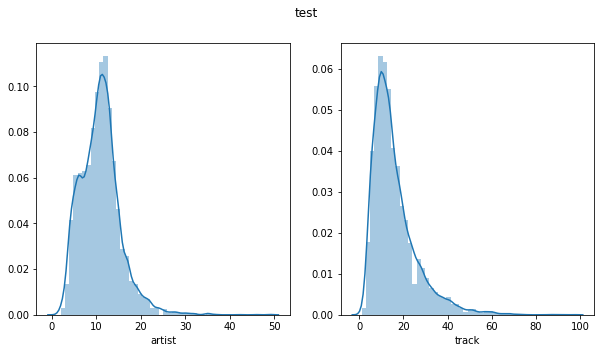

In [0]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

sns.distplot(df_lyrics["artist"].str.len(), ax=axes[0])
sns.distplot(df_lyrics["track"].str.len(), ax=axes[1])
fig.suptitle("Artist & Track name lengths")
plt.show();

In [0]:
df_lyrics["artist"].str.len().describe()

count    8802.000000
mean       10.889684
std         4.503277
min         1.000000
25%         8.000000
50%        11.000000
75%        13.000000
max        49.000000
Name: artist, dtype: float64

In [0]:
mask = df_lyrics["artist"].str.len().sort_values(ascending=False).index
df_lyrics["artist"].reindex(mask).head(20)

id
6gQZKkphKIMxZgca5r7ImA    charles wright the watts 103rd street rhythm band
4pW3aTX3kAmOaPJfc9UM12    charles wright the watts 103rd street rhythm band
2JdzB67NvIa90K4gEZPLeX       the presidents of the united states of america
2BeFYfKuc0AZGhbeVY78ep           buster poindexter and his banshees of blue
4cIwg5VY8Lo1NYwq7llOth                ben harper and the innocent criminals
2TgWDoM6CaKmndboIrbAB3                 caroline smith the good night sleeps
73gwh6fPYSFIt2z52f7a4Y                 lukas nelson and promise of the real
7cRpjY0KWGmfZjcePxyGSl                  nathaniel rateliff the night sweats
0gqxf8wrEkewjmZB7OT4mL                  nathaniel rateliff the night sweats
1AWeNwfENzCxtqKG3bYF0x                  nathaniel rateliff the night sweats
1hWQvA6oGVJ2mAVsZ59AaV                  nathaniel rateliff the night sweats
4bhTJfVPynHxot7dlVNgq7                  nathaniel rateliff the night sweats
2CR3rZKwLWNMXDLooqpFHV                  nathaniel rateliff the night sweats
4peHmvHrn

In [0]:
df_lyrics["track"].str.len().describe()

count    8802.000000
mean       15.871393
std        10.138370
min         1.000000
25%         9.000000
50%        13.000000
75%        20.000000
max        97.000000
Name: track, dtype: float64

In [0]:
mask = df_lyrics["track"].str.len().sort_values(ascending=False).index
df_lyrics["track"].reindex(mask).head(20)

id
6YEOmCsXSk9ZPE0FkcCiuQ    layla acoustic live at mtv unplugged bray film...
0KnZ3Fgnqjmz4Sl2OA5zwa    la copa de la vida la cancion oficial de la co...
66LhCsc06aTa2Ig7iYPDSP    stop draggin my heart around with tom petty th...
6PUIzlqotEmPuBfjbwYWOB    summertime sadness lana del rey vs cedric gerv...
6JV2JOEocMgcZxYSZelKcc    can t stop the feeling original song from drea...
1WkMMavIMc4JZ8cfMmxHkI    can t stop the feeling original song from drea...
1psvUvFwbAKN0Vc0TAlZTp    the revenge of the bomberclad joint the kruder...
252Js3mNvVOHzeiStTUTNM     you make me feel like a natural woman recorde...
5Knl7BTPCME3Kh5WxctWLU    what have i done to deserve this with dusty sp...
1zJpJ3HPRtAYYNLWm5BJEf    if i ain t got you james bay spotify session 2...
1s99Qkm5GtZ1ufweMDOfzQ    the only thing worth fighting for from the hbo...
4WUipVjYtYBlxjMDTjySrG    if i ain t got you james bay spotify session 2...
3y3brCCecHC3Db18aIOnny    carry on from the original motion picture poké...
1PfUKiMDK

In [0]:
# tidy up lyric data
import re
def artist_cleaner(text):
  doc = re.sub(r'-',' ', text)
  doc = re.sub(r'\[','', text)
  doc = re.sub(r'\]','', text)
  doc = re.sub(r'\(','', text)
  doc = re.sub(r'\)','', text)
  # remove special chars
  doc = re.sub(r'\W', ' ', doc)
  # set to lowercase
  doc = doc.lower()
  # remove line breaks
  doc = re.sub(r"\n", " ", doc)
  # remove music terminology
  doc = re.sub(r"feature.*$", "", doc)
  doc = re.sub(r"featuring.*$", "", doc)
  doc = re.sub(r"remix.*$", "", doc)
  # substituting multiple spaces with single space
  doc = re.sub(r'\s+', ' ', doc, flags=re.I)
  return doc

def track_cleaner(text):
  doc = re.sub(r'-',' ', text)
  doc = re.sub(r'\[','', text)
  doc = re.sub(r'\]','', text)
  doc = re.sub(r'\(','', text)
  doc = re.sub(r'\)','', text)
  # remove special chars
  doc = re.sub(r'\W', ' ', doc)
  # set to lowercase
  doc = doc.lower()
  # remove line breaks
  doc = re.sub(r"\n", " ", doc)
  # remove music terminology
  doc = re.sub(r"feat.*$", "", doc)
  doc = re.sub(r"feature.*$", "", doc)
  doc = re.sub(r"featuring.*$", "", doc)
  doc = re.sub(r"remix.*$", "", doc)
  doc = re.sub(r"live.*$", "", doc)
  doc = re.sub(r"acoustic.*$", "", doc)
  doc = re.sub(r"with.*$", "", doc)
  doc = re.sub(r" vs.*$", "", doc)
  doc = re.sub(r"spotify.*$", "", doc)
  doc = re.sub(r"remastered.*$", "", doc)
  doc = re.sub(r"music from the original.*$", "", doc)
  doc = re.sub(r"original motion.*$", "", doc)
  doc = re.sub(r"original song.*$", "", doc)
  doc = re.sub(r"recorded at.*$", "", doc)
  doc = re.sub(r"studio recording.*$", "", doc)
  doc = re.sub(r"soundtrack.*$", "", doc)
  doc = re.sub(r"from the hbo.*$", "", doc)
  # substituting multiple spaces with single space
  doc = re.sub(r'\s+', ' ', doc, flags=re.I)
  return doc

df_lyrics["artist"] = [artist_cleaner(artist) for artist in df_lyrics["artist"]]
df_lyrics["track"] = [track_cleaner(track) for track in df_lyrics["track"]]

df_lyrics.head()

,artist,album,track
id,,,
005lwxGU1tms6HGELIcUv9,katy perry,one of the boys,i kissed a girl
008EXmFGIPz7DWuOVIl5hP,rosie carney,your love is holy,your love is holy
00AVBnaQz7yRv8NTpNlCVU,albin lee meldau,lovers,bloodshot demo
00DTeE4nekCTgYz1QYHXSl,invention_,fokus,nature bump 000
00DrIsn8msfbQf3Let6UTD,voyager,bridge,third bridge


In [0]:
mask = df_lyrics["track"].str.len().sort_values(ascending=False).index
df_lyrics["track"].reindex(mask).head(20)

id
0KnZ3Fgnqjmz4Sl2OA5zwa    la copa de la vida la cancion oficial de la co...
1psvUvFwbAKN0Vc0TAlZTp    the revenge of the bomberclad joint the kruder...
1PfUKiMDKIlPEF9FfdJawc    hope is a dangerous thing for a woman like me ...
6KawDsALZTY6FA8CE1NLZK    i remember clifford rudy van gelder edition 20...
7EQnEtX1pgFpnoxP9CM2gJ    i know it s pathetic but that was the greatest...
7wrvNHeaoRB0jvjXpDEvwK    have it all easy star all stars michael goldwa...
51c94ac31swyDQj9B3Lzs3    change in the house of flies in the house of f...
5GTEB0XsQBwCaiJYaIRCgg    let s make love and listen to death from above...
5cvbog6wen3r3bBbcwL16U    we ve never met but can we have a cup of coffe...
1WSGTYKLEpKfNQYYW5Oymt    i can t get enough benny blanco selena gomez j...
61oEC3ZjyitXj5KUzqCsYr    sisters are doin it for themselves than never ...
6l7PbHcApOcdXYbZlex1z4    slip into something more comfortable stephen h...
0CPwNXw5qD9588d86nropo    this old heart of mine is weak for you single ...
33CfD8UkD

In [0]:
# export data locally
#from google.colab import files
filename = "spotify_lyrics_raw"
df_lyrics.to_csv(filename + ".csv", index=True)
files.download(filename + ".csv")

### Get Lyrics Data

In [0]:
for idx in df_lyrics.index[:5]:
  print("{}: {}".format(df_lyrics["artist"][idx],
                       df_lyrics["track"][idx]))

katy perry: i kissed a girl
rosie carney: your love is holy
albin lee meldau: bloodshot demo
invention_: nature bump 000
voyager: third bridge


In [0]:
# create lyrics column
#df_lyrics["lyrics_raw"] = np.NaN

# get batch size
batch_size = 100
batch_num = len(range(0,len(df_lyrics),batch_size))
print("Number of batches: {}".format(batch_num))

def get_lyrics(n=0, batchsize=100, df=df_lyrics):
  # set batches
  batches = range(0, len(df), batchsize)
  #new_lyrics = []
  
  # get lyric data in batches
  print("Starting Batch {}... ".format(n+1))
  
  for idx in range(len(df))[batches[n]:batches[n]+batchsize]:
    # find song with genius lyrics API
    genius = lyricsgenius.Genius(client_access_token)
    gen_search = genius.search_song(df["track"][idx], df["artist"][idx])
    
    #if type(gen_search) == lyricsgenius.song.Song:
    try:
      # if search is successful, get lyrics
      df["lyrics_raw"].iloc[idx] = gen_search.lyrics
    #else:
    except (RuntimeError, TypeError, AttributeError):
      #df["lyrics_raw"].iloc[idx] = np.NaN
      pass
      
  print("\nFinished Batch {}... {} song lyrics retrieved.".format(n+1, len(df)-df["lyrics_raw"].isna().sum()))
  print('{}% of total songs done.\n'.format(np.round(((batches[n]+batchsize) / len(df) * 100), 2)))

Number of batches: 89


In [0]:
#df_lyrics_batch1 = df_lyrics.copy()

#for n in range(0,30):
#  get_lyrics(n)

#print(df_lyrics_batch1.shape)
#print(df_lyrics_batch1["lyrics_raw"].dropna().shape)
#print(df_lyrics_batch1.tail(10))

In [0]:
## export data locally
#from google.colab import files
#filename = "spotify_lyrics_raw_batch1"
#df_lyrics_batch1.to_csv(filename + ".csv", index=True)
#files.download(filename + ".csv")

In [0]:
#df_lyrics_batch2 = df_lyrics_batch1.copy()

#for n in range(30,60):
#  get_lyrics(n)
  
#print(df_lyrics_batch2.shape)
#print(df_lyrics_batch2["lyrics_raw"].dropna().shape)
#print(df_lyrics_batch2.tail(10))

Starting Batch 31... 
Searching for "why hide " by mark ronson...
Done.
Searching for "are you that somebody" by lynn olsen...


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Done.
Searching for "if you re gone" by matchbox twenty...
Done.
Searching for "friday morning " by khruangbin...
Done.
Searching for "right me up" by state radio...
Done.
Searching for "honey" by tosca...
Done.
Searching for "i second that emotion" by smokey robinson the miracles...
Done.
Searching for "words music from the film tig " by sharon van etten...
No results found for: 'words music from the film tig  sharon van etten'
Searching for "hurt people " by gryffin...
Done.
Searching for "stranger still " by blossoms...
Done.
Searching for "fire and rain" by james taylor...
Done.
Searching for "keep it to yourself" by kacey musgraves...
Done.
Searching for "recrd" by eyukaliptus...
No results found for: 'recrd eyukaliptus'
Searching for "favorite liar" by the wrecks...
Done.
Searching for "jolene" by ray lamontagne...
Done.
Searching for "bad liar" by selena gomez...
Done.
Searching for "morning light" by wilderado...
Done.
Searching for "human error" by oh land...
Done.
Searching f

In [0]:
# export data locally
#from google.colab import files
#filename = "spotify_lyrics_raw_batch2"
#df_lyrics_batch2.to_csv(filename + ".csv", index=True)
#files.download(filename + ".csv")

In [0]:
#df_lyrics_batch3 = df_lyrics_batch2.copy()
df_lyrics_batch3 = df_lyrics.copy()

for n in range(60,89):
  get_lyrics(n=n, df=df_lyrics_batch3)
  
print(df_lyrics_batch3.shape)
print(df_lyrics_batch3["lyrics_raw"].dropna().shape)
print(df_lyrics_batch3.tail(10))

Starting Batch 61... 
Searching for "we are family" by sister sledge...
Done.
Searching for "escape the pina colada song" by rupert holmes...
Done.
Searching for "wolves" by phosphorescent...
Done.
Searching for "as we ran" by the national parks...
Done.
Searching for "crazy in love " by beyoncé...
Done.
Searching for "king of everything" by dominic fike...
Done.
Searching for "taste " by tyga...
Done.
Searching for "comes and goes" by bobby i miss you...
Done.
Searching for "ciruela" by dontcry...
No results found for: 'ciruela dontcry'
Searching for "for what it s worth" by liam gallagher...
Done.
Searching for "the city " by louis the child...
Done.
Searching for "breakdown" by jack johnson...
Done.
Searching for "can t buy happiness" by tash sultana...
Done.
Searching for "morning sun " by potatohead people...
Done.
Searching for "wake me up before you go go" by wham ...
Done.
Searching for "summer noon" by tweedy...
Done.
Searching for "call 9 1 1" by westside connection...
Done.


In [0]:
df_lyrics = df_lyrics_batch3.copy()
print(df_lyrics.shape)
print(df_lyrics.dropna().shape)
df_lyrics.head()

(8802, 4)
(8196, 4)


,artist,album,track,lyrics_raw
id,,,,
005lwxGU1tms6HGELIcUv9,katy perry,one of the boys,i kissed a girl,[Verse 1]\nThis was never the way I planned\nN...
008EXmFGIPz7DWuOVIl5hP,rosie carney,your love is holy,your love is holy,[Verse 1]\nTake me down\nI want to stay\nIn yo...
00AVBnaQz7yRv8NTpNlCVU,albin lee meldau,lovers,bloodshot demo,[Verse 1]\nMonday morning be coming\nAs I hang...
00DTeE4nekCTgYz1QYHXSl,invention_,fokus,nature bump 000,Preparatory to anything else Mr Bloom brushed ...
00DrIsn8msfbQf3Let6UTD,voyager,bridge,third bridge,"In the year 1799, Captain Amasa Delano, of Dux..."


In [0]:
# export data locally
from google.colab import files
filename = "spotify_lyrics_raw"
df_lyrics.to_csv(filename + ".csv", index=True)
files.download(filename + ".csv")

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 57748, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil